## Generate synthetic data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import jax

jax.config.update('jax_enable_x64', True)

import tmac.models as tm
import tmac.preprocessing as tp
from tmac.synthetic_data import col_corr, generate_synthetic_data, ratio_model

# set the parameters of the synthetic data
num_ind = 1000
num_neurons = 50
mean_r = 20
mean_g = 30
variance_noise_r_true = 0.2**2
variance_noise_g_true = 0.2**2
variance_a_true = 0.3**2
variance_m_true = 0.3**2
tau_a_true = 3
tau_m_true = 3
frac_nan = 0.05
beta = 20

# generate synthetic data
red_bleached, green_bleached, a_true, m_true = generate_synthetic_data(
    num_ind,
    num_neurons,
    mean_r,
    mean_g,
    variance_noise_r_true,
    variance_noise_g_true,
    variance_a_true,
    variance_m_true,
    tau_a_true,
    tau_m_true,
    frac_nan=frac_nan,
    beta=beta,
    multiplicative=False,
)

## Preprocessing

In [2]:
# divide out the photobleaching
red = tp.photobleach_correction(red_bleached)
green = tp.photobleach_correction(green_bleached)

# get rid of nans via linear interpolation
red = tp.interpolate_over_nans(red)
green = tp.interpolate_over_nans(green)


## Inference the model parameters


In [3]:
## Inference the model parameters
trained_variables = tm.tmac_ac(red, green, truncate_freq=False)
# pull out the trained variables
a_trained = trained_variables["a"]
m_trained = trained_variables["m"]
variance_r_noise_trained = trained_variables["variance_r_noise"]
variance_g_noise_trained = trained_variables["variance_g_noise"]
variance_a_trained = trained_variables["variance_a"]
variance_m_trained = trained_variables["variance_m"]
length_scale_a_trained = trained_variables["length_scale_a"]
length_scale_m_trained = trained_variables["length_scale_m"]


## Plotting ##

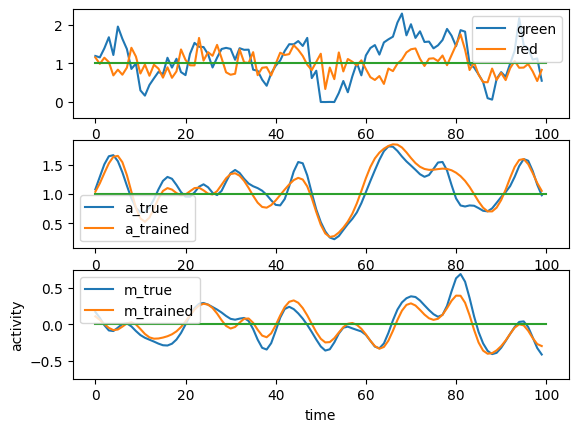

In [4]:


# calculate the prediction from the ratio model
ratio = ratio_model(red, green, tau_a_true / 2)

# choose which neuron to plot and at what time indicies
plot_ind = 0
plot_start = 150
plot_time = 100

fig = plt.figure()
green_fold_change = green / np.mean(green, axis=0)
red_fold_change = red / np.mean(red, axis=0)
# plot the green fluorescence
ax = fig.add_subplot(3, 1, 1)
ax.plot(green_fold_change[plot_start : plot_start + plot_time, plot_ind])
ax.plot(red_fold_change[plot_start : plot_start + plot_time, plot_ind])
ax.plot([0, plot_time], [1, 1])
lims = np.array(ax.get_ylim())
lim_to_use = np.max(np.abs(lims - 1))
ax.set_ylim(-lim_to_use + 1, lim_to_use + 1)
ax.legend(["green", "red"])
ax = fig.add_subplot(3, 1, 2)
ax.plot(a_true[plot_start : plot_start + plot_time, plot_ind])
ax.plot(a_trained[plot_start : plot_start + plot_time, plot_ind])
ax.plot([0, plot_time], [1, 1])
lims = np.array(ax.get_ylim())
lim_to_use = np.max(np.abs(lims - 1))
ax.set_ylim(-lim_to_use + 1, lim_to_use + 1)
ax.legend(["a_true", "a_trained"])

# plot the motion artifact
ax = fig.add_subplot(3, 1, 3)
ax.plot(m_true[plot_start : plot_start + plot_time, plot_ind])
ax.plot(m_trained[plot_start : plot_start + plot_time, plot_ind])
ax.plot([0, plot_time], [0, 0])
lims = ax.get_ylim()
lim_to_use = np.max(np.abs(lims))
ax.set_ylim(-lim_to_use, lim_to_use)
ax.legend(["m_true", "m_trained"])
ax.set_xlabel("time")
ax.set_ylabel("activity")
plt.show()

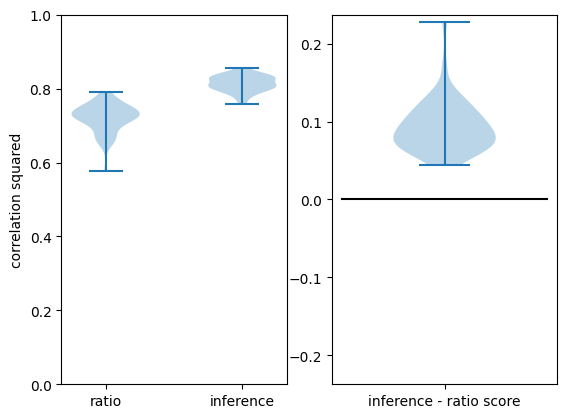

In [5]:
# ratio vs TMAC performance
ratio_corelation_squared = col_corr(a_true, ratio) ** 2
tmac_corelation_squared = col_corr(a_true, a_trained) ** 2

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.violinplot([ratio_corelation_squared, tmac_corelation_squared])
ax.set_ylim(0, 1)
ax.set_ylabel("correlation squared")
ax.set_xticks([1, 2])
ax.set_xticklabels(["ratio", "inference"])

ax = fig.add_subplot(1, 2, 2)
ax.violinplot(tmac_corelation_squared - ratio_corelation_squared)
lims = ax.get_ylim()
lim_to_use = np.max(np.abs(lims))
ax.set_ylim(-lim_to_use, lim_to_use)
ax.plot([0.5, 1.5], [0, 0], "-k")
ax.set_xticks([1])
ax.set_xticklabels(["inference - ratio score"])
plt.show()

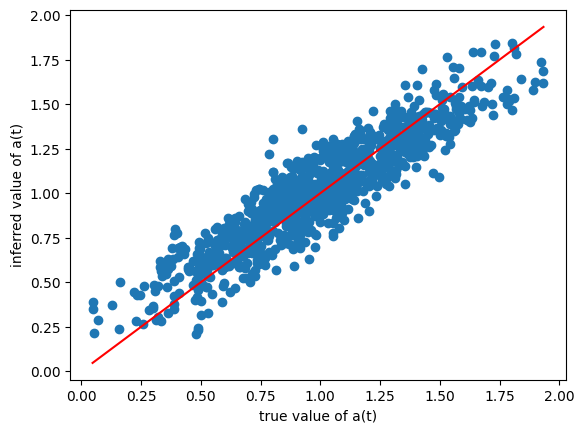

In [6]:
# Plot scatter plot of true activity against inferred activity
# get y=x line
lower = np.min(a_true[:, plot_ind])
upper = np.max(a_true[:, plot_ind])
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(a_true[:, plot_ind], a_trained[:, plot_ind])
ax.plot([lower, upper], [lower, upper], "r")
ax.set_xlabel("true value of a(t)")
ax.set_ylabel("inferred value of a(t)")
plt.show()

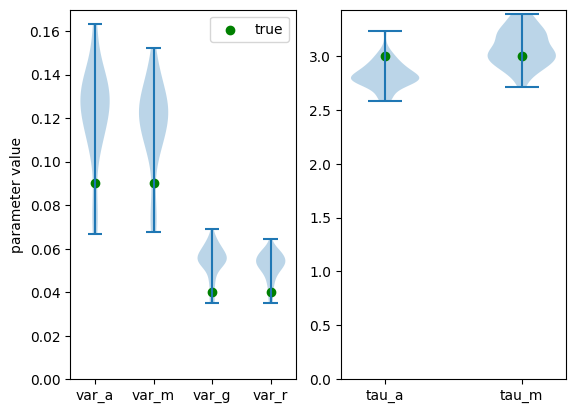

In [7]:
# Violin plot of hyperparameter fits over neurons
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.violinplot(
    [
        variance_a_trained,
        variance_m_trained,
        variance_g_noise_trained,
        variance_r_noise_trained,
    ],
)
ax.scatter(
    np.arange(1, 5),
    [variance_a_true, variance_m_true, variance_noise_g_true, variance_noise_r_true],
    color="g",
    marker="o",
    label = "true"
)
ylim = ax.get_ylim()
ax.set_ylim(0, ylim[1])
ax.set_xticks(np.arange(4) + 1)
ax.set_xticklabels(["var_a", "var_m", "var_g", "var_r"])
ax.set_ylabel("parameter value")
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.violinplot([length_scale_a_trained, length_scale_m_trained])
ax.scatter(np.arange(1, 3), [tau_a_true, tau_m_true], color="g", marker="o", label = "true")
ylim = ax.get_ylim()
ax.set_ylim(0, ylim[1])
ax.set_xticks(np.arange(2) + 1)
ax.set_xticklabels(["tau_a", "tau_m"])
plt.show()
